In [1]:
import librosa
import numpy as np
import os
import copy

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# setting up the data directory
DATA_DIR="cats_dogs/"

Einfach ein Sound Objekt zur leichteren Datenverarbeitung. Cat ist ein Boolean. Spec steht für Spectogramm

In [3]:
class Sound:
    def __init__(self, filePath, cat, spec = None):
        self.filePath = filePath
        self.cat = cat
        self.spec = spec

    def __str__(self):
        return f"Sound(filePath={self.filePath}, cat={self.cat}, spec={self.spec})"
    

In [4]:
audiofiles = []
files = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
dog_counter = 0
cat_counter = 0

for file in files:
    isCat = file.split("_")[0] == "cat"
    if isCat:
        cat_counter += 1
    else:
        dog_counter += 1
    audiofiles.append(Sound(filePath=DATA_DIR+file ,cat=isCat))

print (cat_counter)
print (dog_counter)

164
113


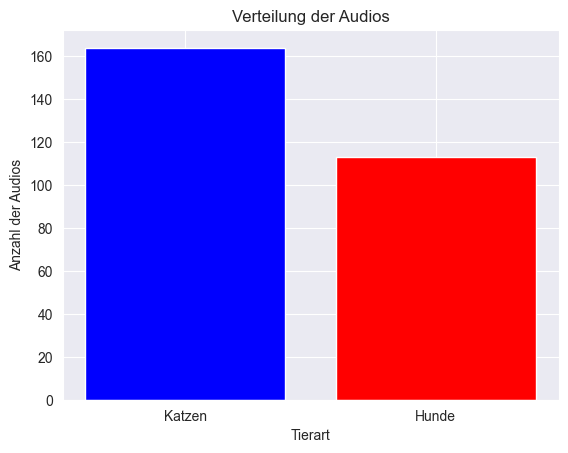

In [5]:
labels = ['Katzen', 'Hunde']
counts = [cat_counter, dog_counter]

plt.bar(labels, counts, color = ['blue', 'red'])

plt.title ('Verteilung der Audios')
plt.xlabel ('Tierart')
plt.ylabel('Anzahl der Audios')

plt.show()

In [6]:
sumDurations  = 0
sumFiles = 0
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    sumDurations += librosa.get_duration(y =y, sr=sr)
    sumFiles += 1

print (sumDurations/sumFiles)
TARGETDURATION = np.ceil(sumDurations/sumFiles)
TARGETDURATION

6.939857887800129


7.0

we now know that the mean duration of an audio sample ist 7.2 seconds so we will try to normalize all audiofiles

We need to normalize the shape of our audio file so we make every sound 7
 seconds long

The function below creates a mel spectogram for given audio input. The input has to be the path of the input. THe audiofile has to be a tupel with the path to the soundfile first and the class second.

In [7]:
def getMelSpecLabel(audiofile:Sound):
    y, sr = librosa.load(audiofile.filePath)
    # Passing through arguments to the Mel filters
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,
                                        fmax=8000)
    audiofile.spec = librosa.power_to_db(S, ref=np.max)

In [8]:
def plotMel(audiofile:Sound):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(audiofile.spec, x_axis='time',
                            y_axis='mel', 
                            fmax=8000, ax=ax)
    if audiofile.cat:
        ax.set(title="Cat")
    else:
        ax.set(title="Dog")
    fig.colorbar(img, ax=ax, format='%+2.0f dB')

ich würde gerne die verteilung der Längen der audiodaten kennen


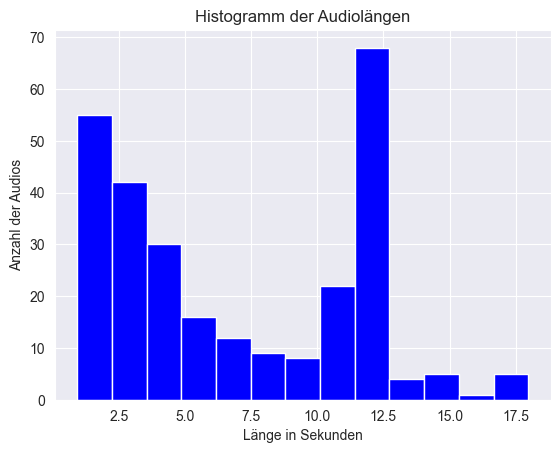

In [9]:

audio_lengths = []
for audiofile in audiofiles:
    y, sr = librosa.load(audiofile.filePath)
    audio_lengths.append(librosa.get_duration(y=y, sr=sr))

plt.hist(audio_lengths, bins=13, color='blue')
plt.title('Histogramm der Audiolängen')
plt.xlabel('Länge in Sekunden')
plt.ylabel('Anzahl der Audios')
plt.show()

[[-58.61299  -41.643627 -37.16182  ... -65.08957  -64.84053  -63.39923 ]
 [-65.794785 -56.060455 -54.005676 ... -66.68897  -62.772957 -58.957684]
 [-74.54154  -61.993736 -55.103016 ... -64.10698  -59.95697  -57.796425]
 ...
 [-76.15093  -63.55017  -53.9777   ... -80.       -80.       -80.      ]
 [-76.17961  -64.40683  -56.657074 ... -80.       -80.       -80.      ]
 [-80.       -78.376816 -70.65631  ... -80.       -80.       -80.      ]]


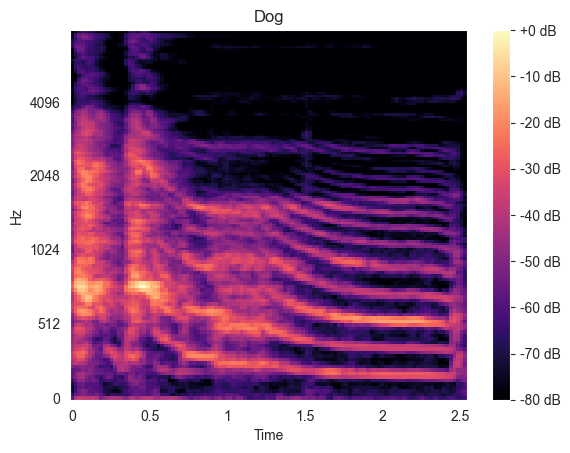

In [10]:
num = 3
processedData = getMelSpecLabel(audiofile=audiofiles[num])
print(audiofiles[num].spec)
plotMel(audiofiles[num])
#print(processedData[0].shape)


Next we have to Resize all Spectogramms to the same input shape. By converting into a mel spectogramm every Spectotramm has a heigt (first dimension) of 128, the second demension should have a length of 311

In [11]:
def pad_resize(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
      audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            new_column = np.array([audiofile.spec[:, counter]]).reshape(128,1)
            audiofile.spec = np.hstack((audiofile.spec, new_column))
            counter += 1

def pad_nulls(audiofile:Sound, width:int):
    if audiofile.spec.shape[1] > width:
        audiofile.spec = audiofile.spec[:, :width]
    else:
        counter = 0
        while audiofile.spec.shape[1] < width:
            audiofile.spec = np.hstack((audiofile.spec, np.zeros(shape=(128,1))))
            counter += 1


In [12]:
def mask_random(Sound, mask_probability=0.20):
    newSound = copy.deepcopy(Sound) 
    arr = newSound.spec
    new = False 
    if newSound.cat:
        mask_probability = 0.30
    if np.random.rand() < mask_probability:
        mask_rows = np.random.choice([True, False])
        new = True 

        if mask_rows:
            # Mask random block of rows
            num_rows = arr.shape[0]
            min_rows_to_mask = max(1, int(0.075 * num_rows))  # Minimum number of rows to mask (at least 7.5%)
            max_rows_to_mask = min(int(0.20 * num_rows), num_rows)  # Maximum number of rows to mask (at most 15%)
            num_rows_to_mask = np.random.randint(min_rows_to_mask, max_rows_to_mask + 1)  # Random number of rows to mask
            start_row = np.random.randint(0, num_rows - num_rows_to_mask + 1)  # Start row index for masking
            arr[start_row:start_row + num_rows_to_mask, :] = 0  # Mask selected rows with zeros
        else:
            # Mask random block of columns
            num_cols = arr.shape[1]
            min_cols_to_mask = max(1, int(0.075 * num_cols))  # Minimum number of columns to mask (at least 7.5%)
            max_cols_to_mask = min(int(0.20 * num_cols), num_cols)  # Maximum number of columns to mask (at most 15%)
            num_cols_to_mask = np.random.randint(min_cols_to_mask, max_cols_to_mask + 1)  # Random number of columns to mask
            start_col = np.random.randint(0, num_cols - num_cols_to_mask + 1)  # Start column index for masking
            arr[:, start_col:start_col + num_cols_to_mask] = 0  # Mask selected columns with zeros

    return newSound, new

277
277


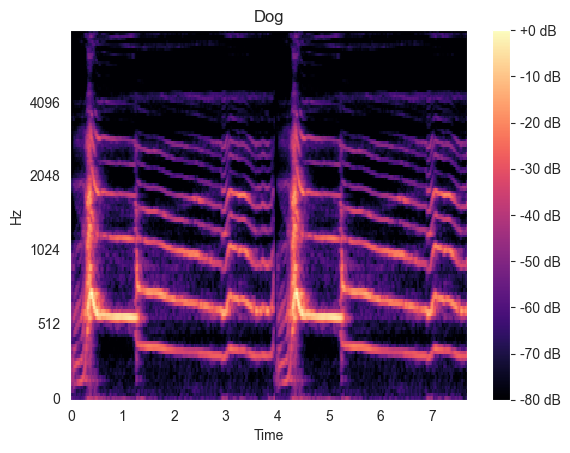

In [13]:
num = 1
getMelSpecLabel(audiofiles[num])
# pad_nulls(audiofiles[num], 331)
pad_resize(audiofiles[num], 331)
plotMel(audiofiles[num])
print(len(audiofiles))

print(len(audiofiles))

In [14]:
sameLengthMel = []
label = []
for audiofile in audiofiles:
    getMelSpecLabel(audiofile=audiofile)
    pad_resize(audiofile=audiofile, width=331)
    modified_array, new_array_created  = mask_random(audiofiles[num])
    if new_array_created:
        audiofiles.append(modified_array)
        
for audiofile in audiofiles:
    sameLengthMel.append(audiofile.spec.reshape((128,331,1)))
    if audiofile.cat:
        label.append("Cat")
    else:
        label.append("Dog")
features = np.array(sameLengthMel)
labels = np.array(label)

In [15]:
features[0].shape

(128, 331, 1)

## The Model

In [16]:
model = keras.Sequential(layers=[
        # input shape aller daten muss gleich sein -> deswegen resizing funktion
        keras.layers.InputLayer(input_shape=features[0].shape),
        keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
        keras.layers.MaxPooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(2, activation=keras.activations.softmax)
    ])
# warum adam _> keine ahnung
# legacy -> weil training auf m2 chip nicht mit dem normalen geht
model.compile(optimizer=keras.optimizers.legacy.Adam(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 331, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 165, 16)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 165, 32)       4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 82, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 83968)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [17]:
def one_hot(array):
    unique, inverse = np.unique(labels, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot
encoded_labels = one_hot(labels)

In [18]:
# Set parameters for data splitting and training
TEST_SIZE = 0.2

# 2^x gewählt weil -> macht man halt so
BATCH_SIZE = 48
EPOCHS = 50

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE)

# Train the model

# val Daten fürs early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/50
5/5 [==============================] - 1s 126ms/step - loss: 207.2032 - accuracy: 0.5507 - val_loss: 72.4371 - val_accuracy: 0.5088
Epoch 2/50
5/5 [==============================] - 1s 113ms/step - loss: 26.9987 - accuracy: 0.5683 - val_loss: 0.4722 - val_accuracy: 0.8070
Epoch 3/50
5/5 [==============================] - 1s 114ms/step - loss: 1.3146 - accuracy: 0.7885 - val_loss: 0.5508 - val_accuracy: 0.7018
Epoch 4/50
5/5 [==============================] - 1s 116ms/step - loss: 0.2613 - accuracy: 0.9119 - val_loss: 0.4083 - val_accuracy: 0.8421
Epoch 5/50
5/5 [==============================] - 1s 117ms/step - loss: 0.2543 - accuracy: 0.9119 - val_loss: 0.2160 - val_accuracy: 0.9649
Epoch 6/50
5/5 [==============================] - 1s 116ms/step - loss: 0.0228 - accuracy: 0.9956 - val_loss: 0.1625 - val_accuracy: 0.9649
Epoch 7/50
5/5 [==============================] - 1s 113ms/step - loss: 0.0060 - accuracy: 1.0000 - val_loss: 0.1678 - val_accuracy: 0.9474
Epoch 8/50
5/5 [

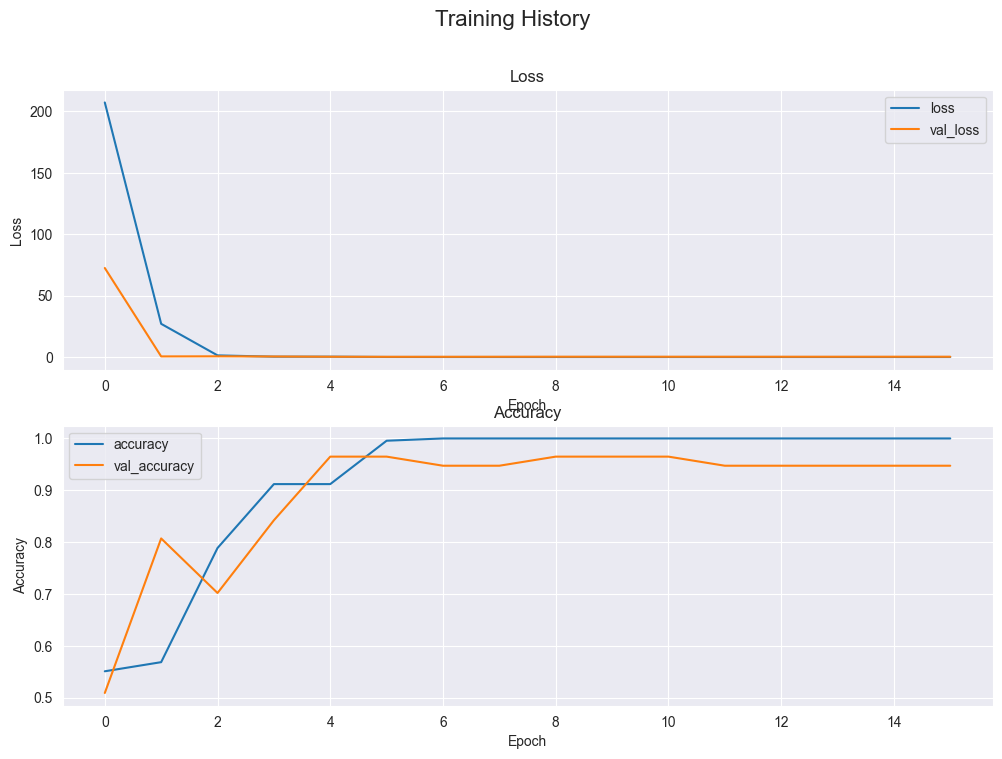

In [19]:
# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

3/3 [==============================] - 0s 21ms/step


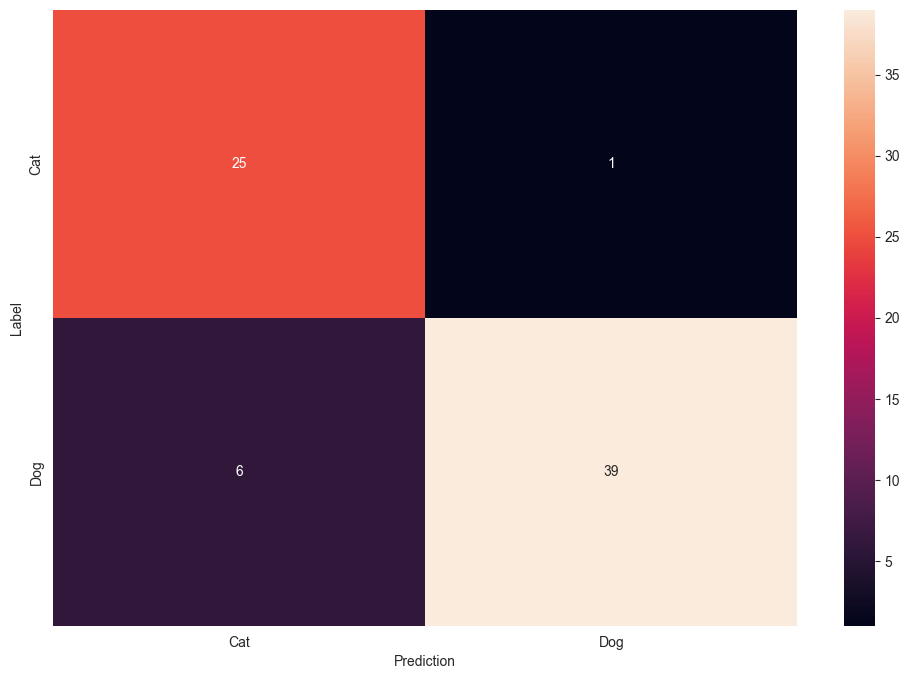

In [20]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [21]:
def predict(audio:Sound):
    getMelSpecLabel(audio)
    pad_resize(audio, 331)
    audio.spec = audio.spec.reshape((1,128,331,1))
    return model.predict(x=sound1.spec)

In [22]:
sound1 = Sound(DATA_DIR + "cat_3.wav", True)
print(predict(sound1))

1/1 [==============================] - 0s 23ms/step
[[0.88168013 0.11831986]]


In [23]:
len(audiofiles)

355